**Interpolation Paper**

In [191]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [192]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [193]:
# Load the data
data_path = r"C:\Users\tmollick\Desktop\Temperature Forecast\combined_1984_2027_converted.csv"
df = pd.read_csv(data_path)

In [194]:
# Clean the data
df.columns = df.columns.str.strip()
df.columns = df.columns.str.rstrip()
df.columns = df.columns.str.lstrip()

df.head()

,DATE,Station,Latitude,Longitude,Elevation,TempMax,TempMin,Rainfall,RelativeHumidity,WindSpeed,CloudCoverage,BrightSunshine,NDVI
0,1/1/1984,5,22.2167,91.8,5.5,25.551613,13.700000,5.368421,72.111111,3.033333,0.700,6.411131,0.419788
1,2/1/1984,5,22.2167,91.8,5.5,27.586207,16.700000,7.789474,65.777778,3.166667,0.975,6.411131,0.392654
2,3/1/1984,5,22.2167,91.8,5.5,30.016129,21.233333,26.842105,71.333333,3.800000,2.150,6.411131,0.406030
3,4/1/1984,5,22.2167,91.8,5.5,31.743333,23.900000,121.842105,77.333333,3.733333,3.325,6.411131,0.423728
4,5/1/1984,5,22.2167,91.8,5.5,32.022581,24.933333,340.736842,79.666667,3.900000,4.875,6.411131,0.419814


In [195]:
# Verify the conversion
print(df['TempMax'].dtype)

float64


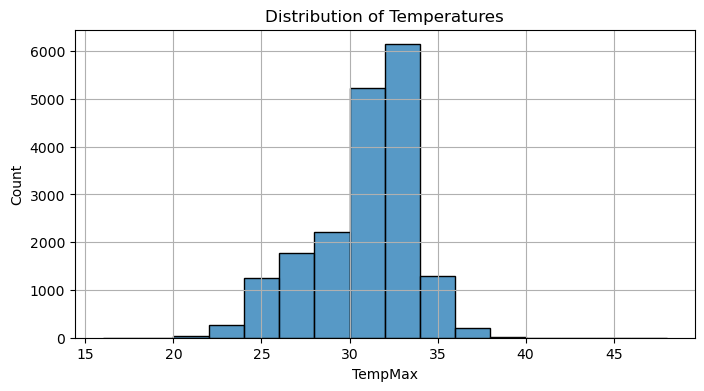

In [196]:
# Plot to see the temperature variance
plt.figure(figsize=(8, 4))
sns.histplot(df['TempMax'], bins=[i for i in range(16, 50, 2)], kde=False)
plt.title("Distribution of Temperatures")
plt.grid()
plt.show()

In [197]:
# Set data index as datetime column
df.index = pd.to_datetime(df.DATE)
df.sort_index(inplace=True)

In [198]:
# Select required columns
required_cols = ['Station', 'Latitude', 'Longitude', 'Elevation', 'TempMax',
                 'TempMin', 'Rainfall', 'RelativeHumidity', 'WindSpeed', 'CloudCoverage',
                 'BrightSunshine', 'NDVI']
df = df[required_cols]
df_final = df.copy()
df_final.head()


,Station,Latitude,Longitude,Elevation,TempMax,TempMin,Rainfall,RelativeHumidity,WindSpeed,CloudCoverage,BrightSunshine,NDVI
DATE,,,,,,,,,,,,
1984-01-01,5,22.2167,91.8000,5.50,25.551613,13.700000,5.368421,72.111111,3.033333,0.700000,6.411131,0.419788
1984-01-01,14,22.4500,92.0000,2.44,24.270968,13.800000,13.000000,71.000000,1.100000,1.200000,7.737931,0.354350
1984-01-01,33,24.9000,91.8833,33.53,24.400000,11.800000,8.000000,72.000000,1.100000,1.100000,7.600000,0.394566
1984-01-01,10,23.7833,90.3833,8.45,24.864516,13.100000,13.000000,69.000000,0.300000,1.400000,7.600000,0.288693
1984-01-01,34,24.2500,89.9333,10.20,24.864516,11.340741,5.548387,80.258065,0.866667,1.240741,6.311111,0.358092


In [199]:
# Separate the 'Station' column
station_column = df_final['Station']
df_final_numeric = df_final.drop(columns=['Station'])

In [200]:
# Normalize the numeric data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final_numeric)

# Define sequence length and features
sequence_length = 13  # Number of time steps in each sequence
num_features = len(df_final_numeric.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i + sequence_length]
    label = scaled_data[i + sequence_length][df_final_numeric.columns.get_loc('TempMax')]  # 'TempMax' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split the data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(sequences, labels, test_size=0.2, random_state=seed)

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Validation X shape:", val_x.shape)
print("Validation Y shape:", val_y.shape)

Train X shape: (14735, 13, 11)
Train Y shape: (14735,)
Validation X shape: (3684, 13, 11)
Validation Y shape: (3684,)


In [201]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2 regularization

# Compile the model with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()


C:\Users\tmollick\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 13, 128)             │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 13, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/BMD_weather_data/BGD_interpolation_papaer_forecast.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=32,  # Experiment with different batch sizes
    validation_data=(val_x, val_y),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
357/357 [==============================] - 26s 48ms/step - loss: 0.0269 - val_loss: 0.0133
Epoch 2/100
357/357 [==============================] - 15s 42ms/step - loss: 0.0117 - val_loss: 0.0068
Epoch 3/100
357/357 [==============================] - 15s 43ms/step - loss: 0.0082 - val_loss: 0.0051
Epoch 4/100
357/357 [==============================] - 15s 42ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 5/100
357/357 [==============================] - 17s 48ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 6/100
357/357 [==============================] - 15s 42ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 7/100
357/357 [==============================] - 15s 42ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 8/100
357/357 [==============================] - 15s 42ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 9/100
357/357 [==============================] - 17s 48ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 10/100
357/357 [==============================] - 15s 42ms/step - l

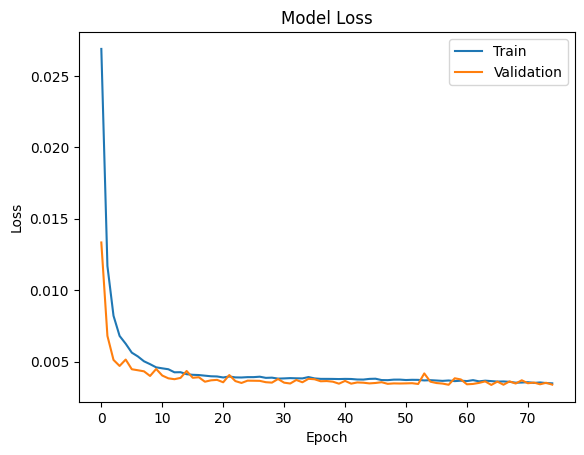

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/BMD_weather_data/BGD_interpolation_papaer_forecast.keras')


In [202]:
# Decompose the time series to extract trend using only TempMax
temp_max_series = df['TempMax']
decomposition = seasonal_decompose(temp_max_series, model='multiplicative', period=365)
trend = decomposition.trend.dropna()

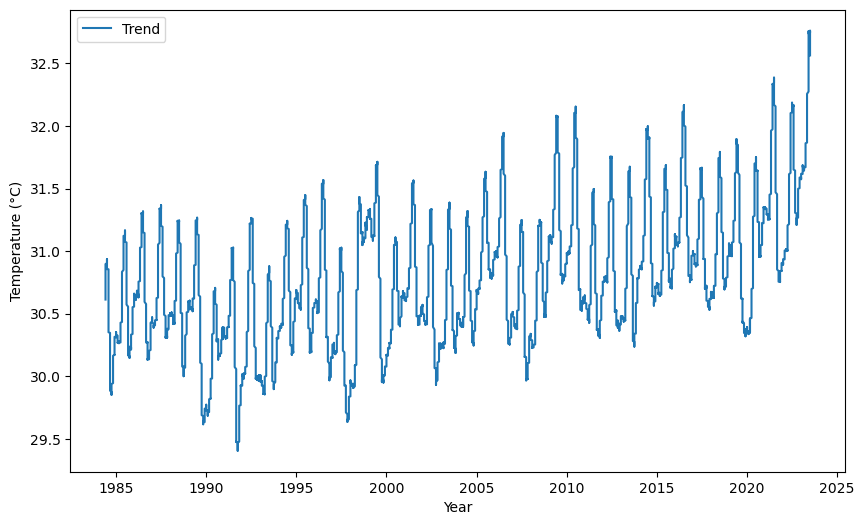

In [25]:
# Plot the trend component
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

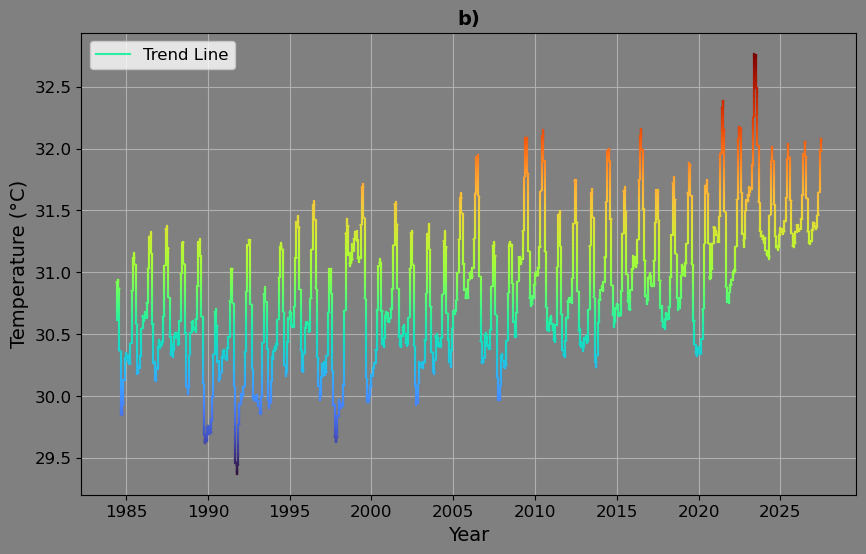

Graph saved as Temperature_trend_1984_2023.png


In [159]:
# Normalize the trend data for colormap
norm = plt.Normalize(vmin=trend.min(), vmax=trend.max())
cmap = plt.get_cmap('turbo')

# Create a color array based on the normalized trend values
colors = cmap(norm(trend))

# Plot the trend component with the color gradient
plt.figure(figsize=(10, 6), facecolor='gray')
ax = plt.gca()
ax.set_facecolor('gray')

#plt.figure(figsize=(10, 6))  # Very light gray background for the figure
#ax = plt.gca()
#ax.set_facecolor('#f0f0f0')  # Very light gray background for the axes

for i in range(len(trend)-1):
    plt.plot(trend.index[i:i+2], trend.values[i:i+2], color=colors[i])

plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('b)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Trend Line'], fontsize=12)
plt.grid(True)

# Save the figure as a PNG file with 300 DPI
output_path = 'Temperature_trend_1984_2023.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"Graph saved as {output_path}")

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

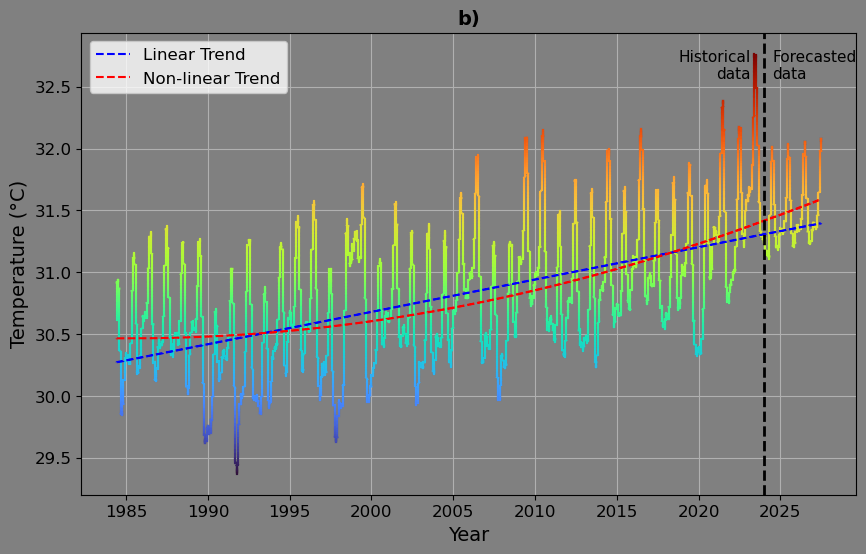

Graph saved as Temperature_trend_1984_2027_ln.png


In [205]:
# Linear trend
X = np.arange(len(trend)).reshape(-1, 1)
linear_model = LinearRegression()
linear_model.fit(X, trend.values)
linear_trend = linear_model.predict(X)

# Non-linear trend (quadratic)
poly = PolynomialFeatures(degree=2)
non_linear_model = make_pipeline(poly, LinearRegression())
non_linear_model.fit(X, trend.values)
non_linear_trend = non_linear_model.predict(X)

# Normalize the trend data for colormap
norm = plt.Normalize(vmin=trend.min(), vmax=trend.max())
cmap = plt.get_cmap('turbo')

# Create a color array based on the normalized trend values
colors = cmap(norm(trend))

# Plot the trend component with the color gradient
plt.figure(figsize=(10, 6), facecolor='gray')
ax = plt.gca()
ax.set_facecolor('gray')

for i in range(len(trend)-1):
    plt.plot(trend.index[i:i+2], trend.values[i:i+2], color=colors[i])

# Plot the linear and non-linear trends
plt.plot(trend.index, linear_trend, label='Linear Trend', color='blue', linestyle='--')
plt.plot(trend.index, non_linear_trend, label='Non-linear Trend', color='red', linestyle='--')

# Draw a vertical dotted line to separate historical and forecasted data
cutoff_date = pd.Timestamp('2024-01-01')
plt.axvline(x=cutoff_date, color='black', linestyle='--', linewidth=2)
plt.text(cutoff_date - pd.Timedelta(days=300), trend.max() - 0.2, 'Historical\ndata', horizontalalignment='right', color='black', fontsize=11)
plt.text(cutoff_date + pd.Timedelta(days=180), trend.max() - 0.2, 'Forecasted\ndata', horizontalalignment='left', color='black', fontsize=11)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
#plt.title('Temperature Trend (1984-2027)', fontsize=14, fontweight='bold')
plt.title('b)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Save the figure as a PNG file with 300 DPI
output_path = 'Temperature_trend_1984_2027_ln.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"Graph saved as {output_path}")

### LST Timeseries

In [142]:
# Load the data
data_path = r"C:\Users\tmollick\Desktop\Temperature Forecast\Final forecasted Data\Monthly_avg_temp_2000_2023.csv"
df = pd.read_csv(data_path)

In [143]:
# Clean the data
df.columns = df.columns.str.strip()
df.columns = df.columns.str.rstrip()
df.columns = df.columns.str.lstrip()

df.head()

,YearMonth,LST
0,2000-02,25.265282
1,2000-03,28.040311
2,2000-04,29.043724
3,2000-05,27.276805
4,2000-06,26.037620


In [144]:
# Set data index as datetime column
df.index = pd.to_datetime(df.YearMonth)
df.sort_index(inplace=True)

In [145]:
df.head()

,YearMonth,LST
YearMonth,,
2000-02-01,2000-02,25.265282
2000-03-01,2000-03,28.040311
2000-04-01,2000-04,29.043724
2000-05-01,2000-05,27.276805
2000-06-01,2000-06,26.037620


In [146]:
# Decompose the time series to extract trend using only TempMax
temp_max_series = df['LST']
decomposition = seasonal_decompose(temp_max_series, model='multiplicative', period=12)
trend = decomposition.trend.dropna()

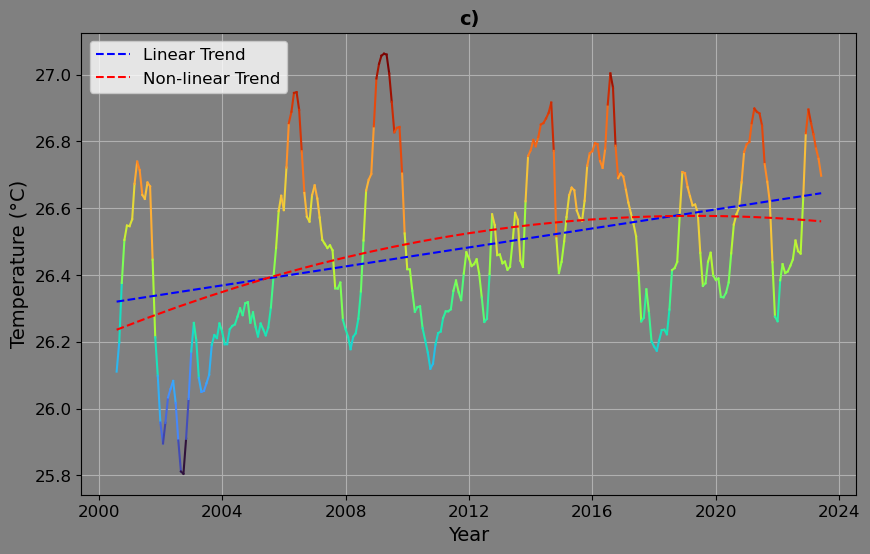

Graph saved as Temperature_trend_2000_2023_LST.png


In [148]:
# Linear trend
X = np.arange(len(trend)).reshape(-1, 1)
linear_model = LinearRegression()
linear_model.fit(X, trend.values)
linear_trend = linear_model.predict(X)

# Non-linear trend (quadratic)
poly = PolynomialFeatures(degree=2)
non_linear_model = make_pipeline(poly, LinearRegression())
non_linear_model.fit(X, trend.values)
non_linear_trend = non_linear_model.predict(X)

# Normalize the trend data for colormap
norm = plt.Normalize(vmin=trend.min(), vmax=trend.max())
cmap = plt.get_cmap('turbo')

# Create a color array based on the normalized trend values
colors = cmap(norm(trend))

# Plot the trend component with the color gradient
plt.figure(figsize=(10, 6), facecolor='gray')
ax = plt.gca()
ax.set_facecolor('gray')

for i in range(len(trend)-1):
    plt.plot(trend.index[i:i+2], trend.values[i:i+2], color=colors[i])

# Plot the linear and non-linear trends
plt.plot(trend.index, linear_trend, label='Linear Trend', color='blue', linestyle='--')
plt.plot(trend.index, non_linear_trend, label='Non-linear Trend', color='red', linestyle='--')


plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('c)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True)

# Save the figure as a PNG file with 300 DPI
output_path = 'Temperature_trend_2000_2023_LST.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"Graph saved as {output_path}")

**Making Blurred Images**

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
image_path = '/content/drive/My Drive/Colab Notebooks/Split_dataset/geo4.jpg'
image = cv2.imread(image_path)

In [9]:
# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(image, (151, 151), 0)

# Blur code example: (15, 15), (51, 51), (101, 101)


In [10]:
# Save the blurred image
blurred_image_path = '/content/drive/My Drive/Colab Notebooks/Split_dataset/geo4_blurred_151.jpg'
cv2.imwrite(blurred_image_path, blurred_image)

# Resize the images for display
scale_percent = 50  # percentage of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)

resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
resized_blurred_image = cv2.resize(blurred_image, dim, interpolation=cv2.INTER_AREA)

# Display the original and blurred images in smaller size
cv2_imshow(resized_image)
cv2_imshow(resized_blurred_image)


Output hidden; open in https://colab.research.google.com to view.